In [43]:
# Keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed
from keras.layers import Convolution2D, MaxPooling2D, MaxPooling1D, Conv1D
from keras.optimizers import Adam, SGD
from keras.utils import np_utils

# Others
sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn import metrics
import random
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.pyplot as plt
import mlxtend                                                          

### Defining training, testing and validation subsets

In [18]:
def train_test(features_path, lables_path, test_size, val_size):

    #Loading features and labels
    features = np.load(features_path)
    labels = np.load(labels_path)
    #print('Dimensiones del array features: ', features.shape)
    #print('Dimensiones del array labels: ', labels.shape)


    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=test_size, 
                                                                                            random_state=1, stratify=labels, shuffle='True')
    x_train, x_validation, y_train, y_validation = train_test_split(x_train, y_train, test_size = val_size, 
                                                                                            random_state=1, stratify=y_train, shuffle='True')

    print("Training subsets shape: ", np.shape(x_train))
    print("Validation subset shape: ", np.shape(x_validation))
    print("Testing subsets shape: ", np.shape(x_test))
    n_samples = len(y_train)
    print("Number of training samples: " + str(n_samples))
    dim = np.shape(x_train)[1]

    #Randomm shuffle of data:
    order = np.array(range(n_samples))
    np.random.shuffle(order)
    x_train = x_train[order]
    y_train = y_train[order]

    return x_train, x_test, x_validation, y_train, y_test, y_validation, dim


In [20]:
# Train/Test Split:

features_path = "/Users/miguel.r/Desktop/CITSEM/Sound Event Class - DCASE/SCRIPTS Github/features.npy"
labels_path = "/Users/miguel.r/Desktop/CITSEM/Sound Event Class - DCASE/SCRIPTS Github/labels.npy"
x_train, x_test, x_validation, y_train, y_test, y_validation, dim = train_test(features_path, labels_path, 0.25, 0.1)


Training subsets shape:  (487619, 32)
Validation subset shape:  (54180, 32)
Testing subsets shape:  (180600, 32)
Number of training samples: 487619


In [28]:
# Label Encoder:

lb = LabelEncoder()
y_train_lb = np_utils.to_categorical(lb.fit_transform(y_train))
y_test_lb = np_utils.to_categorical(lb.fit_transform(y_test))
y_validation_lb = np_utils.to_categorical(lb.fit_transform(y_validation))
print('Number of label encoder classes:', len(np.unique(y_train)))

Number of label encoder classes: 15


### Neural Network

In [31]:
def MLP_neural_network(x_train, x_test, x_validation, y_train_lb, y_test_lb, y_validation_lb, 
                                       epochs, batch_size):

    # NEURAL NETWORK ARCHITECTURE.

    dim = np.shape(x_train)[1]
    num_labels = y_train_lb.shape[1]
    act_functions = ['relu', 'sigmoid', 'softmax', 'softplus', 'tanh', 'exponential']

    # 4-layers
    model = Sequential()
    # 1st (input layer)
    model.add(Dense(512, input_shape=(dim,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    # 2nd
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    # 3rd
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    # 4th
    model.add(Dense(128))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    # output layer.
    model.add(Dense(num_labels, activation='softmax'))

    # Compiling and summary.
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    history = model.fit(x_train, y_train_lb, batch_size=batch_size, epochs=epochs, validation_data=(x_validation, y_validation_lb))
    print('Models summary: ')
    model.summary()

    return history, model


In [59]:
# Training Model:

history, model = MLP_neural_network(x_train, x_test, x_validation, y_train_lb, y_test_lb, y_validation_lb, 30, 1000)
print(history)

Train on 487619 samples, validate on 54180 samples
Epoch 1/30
487619/487619 [==============================] - 9s 19us/step - loss: 1.5231 - accuracy: 0.5530 - val_loss: 0.8336 - val_accuracy: 0.7348
Epoch 2/30
487619/487619 [==============================] - 9s 18us/step - loss: 0.8560 - accuracy: 0.7246 - val_loss: 0.6238 - val_accuracy: 0.7999
Epoch 3/30
487619/487619 [==============================] - 9s 19us/step - loss: 0.7014 - accuracy: 0.7756 - val_loss: 0.5463 - val_accuracy: 0.8238
Epoch 4/30
487619/487619 [==============================] - 9s 19us/step - loss: 0.6252 - accuracy: 0.7994 - val_loss: 0.4919 - val_accuracy: 0.8403
Epoch 5/30
487619/487619 [==============================] - 10s 20us/step - loss: 0.5783 - accuracy: 0.8145 - val_loss: 0.4603 - val_accuracy: 0.8515
Epoch 6/30
487619/487619 [==============================] - 10s 20us/step - loss: 0.5463 - accuracy: 0.8251 - val_loss: 0.4317 - val_accuracy: 0.8592
Epoch 7/30
487619/487619 [===========================

### Model Evaluation:

In [60]:
def results(model, x_test, y_test, y_test_lb):

    result = model.predict(x_test)
    cnt = 0
    prediction = []
    for i in range(len(y_test_lb)):

        if(np.amax(result[i])<0.5):
            pred = np.argmax(result[i])
            prediction = np.append(prediction, pred)
        else:
                pred = np.argmax(result[i])
                prediction = np.append(prediction, pred)
                if np.argmax(y_test_lb[i])==pred:
                    cnt+=1

    acc = str(round(cnt*100/float(len(y_test)),2))
    print("Model accuracy: " + acc + "%")
    
    return prediction, acc

def conf_matrix(y_test, prediction):

    cm = confusion_matrix(y_true=y_test,
                      y_pred=prediction)

    fig, ax = plot_confusion_matrix(conf_mat=cm,
                                colorbar=True,
                                show_absolute=False,
                                show_normed=True,figsize=(13, 13),
                                class_names=list(np.unique(y_test)))

    plt.title('Confusion Matrix')
    plt.figure()
    plt.show()


def model_plots(history):

    accu = history.history['accuracy']
    val_accu = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(accu))

    #Training and validation accuracy.
    plt.plot(epochs, accu, 'darkred', label='Training accuracy')
    plt.plot(epochs, val_accu, 'cornflowerblue', label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    #Training and validation loss.
    plt.plot(epochs, loss, 'darkred', label='Training Loss')
    plt.plot(epochs, val_loss, 'cornflowerblue', label='Validation Loss')
    plt.xlabel('Epochs')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


Model accuracy: 87.26%


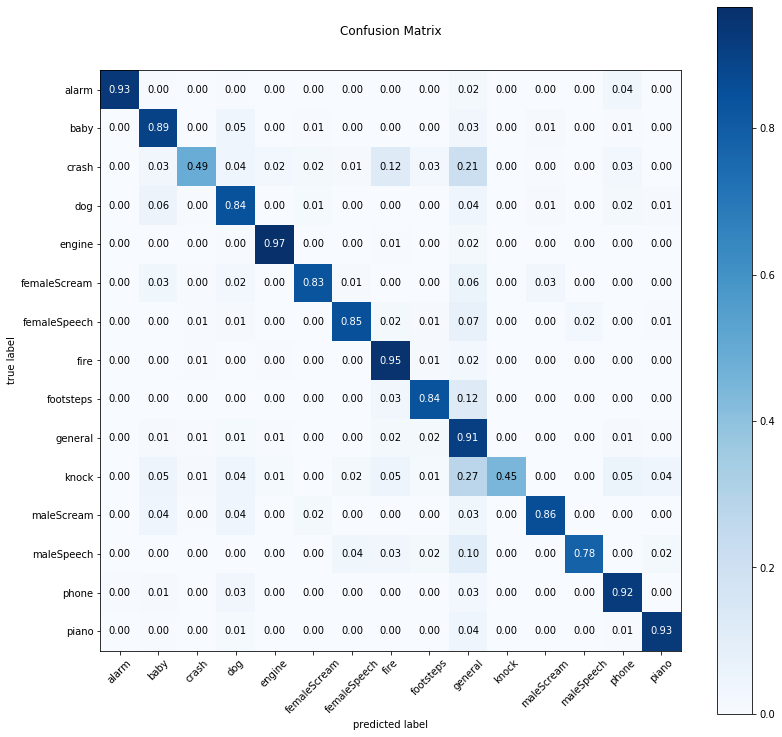

<Figure size 432x288 with 0 Axes>

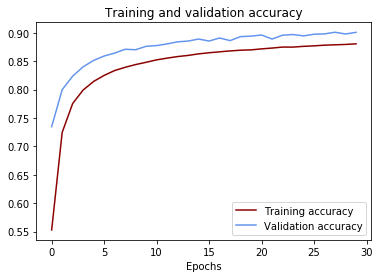

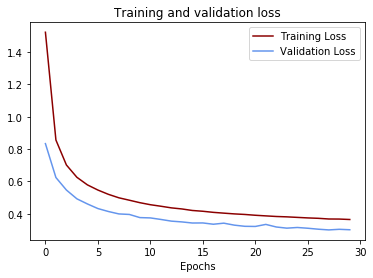

In [61]:
# Quick method to evaluate the model from test dataset:
prediction, acc = results(model, x_test,y_test, y_test_lb)

# Reverse Label Encoder:

prediction = lb.inverse_transform(prediction.astype(int))

# Confusion matrix and model history plots:

conf_matrix(y_test, prediction)
model_plots(history)

### Saving the model:


In [65]:

saving_path = '/Users/miguel.r/Desktop/CITSEM/Sound Event Class - DCASE/SCRIPTS Github/'
model_json = model.to_json()
with open(saving_path+"model_acc_"+acc+".json", "w") as json_file:
    json_file.write(model_json)
model.save_weights(saving_path+"model_acc_"+acc+".h5")
